## Dependencies

In [1]:
import warnings
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
punct_mapping = {"_":" ", "`":" ",   
                 "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", 
                 "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 
                 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi'}

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•', 
          '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
          '½', 'à', '…', '\xa0', '\t', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', 
          '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', 
          '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', 
          '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def clean_punctuation(x):
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def map_punctuation(x):
    for m in punct_mapping:
        x = x.replace(m, punct_mapping[m])  
    return x

In [5]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())
    # Map punctuation
    train[feature] = train[feature].apply(lambda x: map_punctuation(x))
    validation[feature] = validation[feature].apply(lambda x: map_punctuation(x))
    # Clean punctuation
    train[feature] = train[feature].apply(lambda x: clean_punctuation(x))
    validation[feature] = validation[feature].apply(lambda x: clean_punctuation(x))

## Train/validation sets

In [6]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']

X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [7]:
EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 3
RLROP_PATIENCE = 2
DECAY_DROP = 0.3
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

# Model

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

In [9]:
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
embedding_title = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_title)

input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
embedding_body = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_body)

input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
embedding_answer = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_answer)

x = Concatenate()([embedding_title, embedding_body, embedding_answer])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
______________________________________________________________________________________________

# Train model

In [10]:
optimizer = optimizers.Adam(LEARNING_RATE)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid))
callback_list = [es, rlrop, spearmanCallback]
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/40
Train spearman-rho: 0.2147 Validation spearman-rho: 0.1992
4863/4863 - 38s - loss: 0.4928 - val_loss: 0.4145
Epoch 2/40
Train spearman-rho: 0.2885 Validation spearman-rho: 0.2668
4863/4863 - 29s - loss: 0.4070 - val_loss: 0.3996
Epoch 3/40
Train spearman-rho: 0.3273 Validation spearman-rho: 0.3011
4863/4863 - 29s - loss: 0.3965 - val_loss: 0.3926
Epoch 4/40
Train spearman-rho: 0.3512 Validation spearman-rho: 0.3185
4863/4863 - 29s - loss: 0.3905 - val_loss: 0.3885
Epoch 5/40
Train spearman-rho: 0.3694 Validation spearman-rho: 0.3293
4863/4863 - 29s - loss: 0.3862 - val_loss: 0.3857
Epoch 6/40
Train spearman-rho: 0.3830 Validation spearman-rho: 0.3358
4863/4863 - 29s - loss: 0.3829 - val_loss: 0.3839
Epoch 7/40
Train spearman-rho: 0.3941 Validation spearman-rho: 0.3405
4863/4863 - 29s - loss: 0.3811 - val_loss: 0.3824
Epoch 8/40
Train spearman-rho: 0.4038 Validation spearman-rho: 0.3437
4863/4863 - 28s - loss: 0.3780 - val_loss:

## Model loss graph

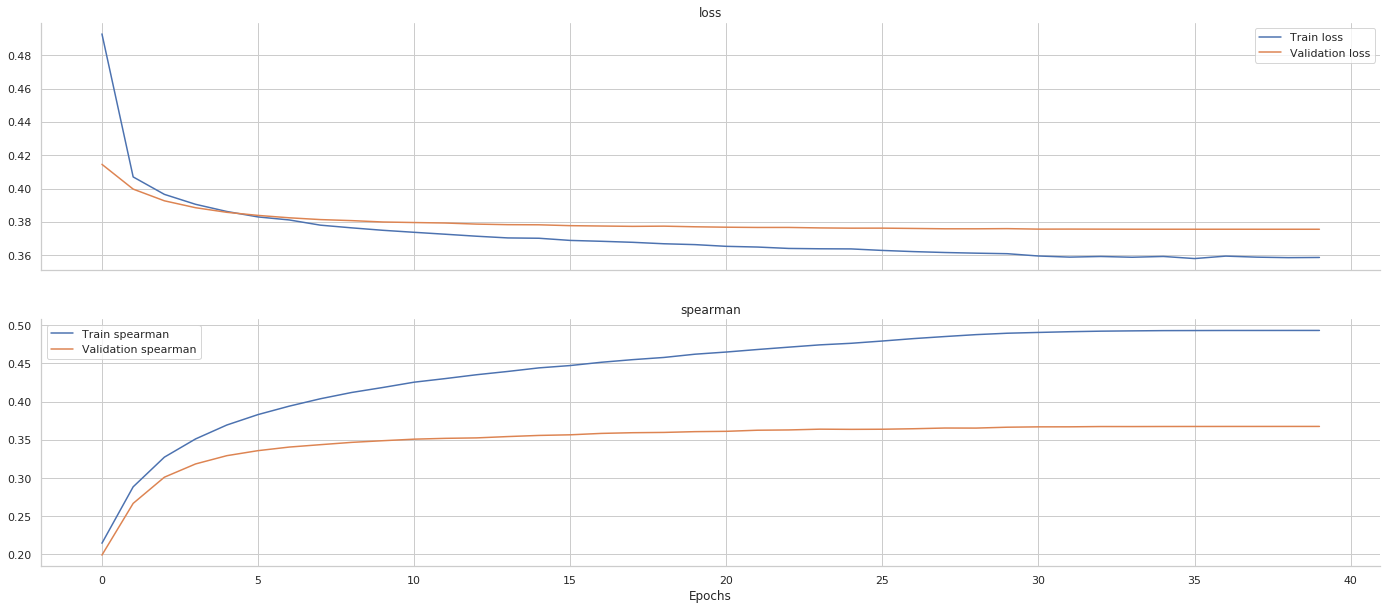

In [11]:
sns.set(style="whitegrid")
for key in spearmanCallback.history.keys():
    history[key] = spearmanCallback.history[key]

plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [12]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.493,0.368
1,question_asker_intent_understanding,0.476,0.409
2,question_body_critical,0.715,0.624
3,question_conversational,0.463,0.407
4,question_expect_short_answer,0.516,0.253
5,question_fact_seeking,0.534,0.337
6,question_has_commonly_accepted_answer,0.558,0.418
7,question_interestingness_others,0.454,0.397
8,question_interestingness_self,0.597,0.532
9,question_multi_intent,0.584,0.420


## By category

In [13]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.463,0.327,0.502,0.367,0.396,0.19,0.517,0.411,0.518,0.381


#### Save model weights

In [14]:
model.save_weights(model_path)